In [1]:
# Install dependencies if needed (uncomment and run once):
# %pip install xarray zarr matplotlib cartopy

In [2]:
# PyCIAM output visualizations with xarray and cartopy
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pathlib import Path

# Load the zarr store as xarray Dataset
zarr_path = Path("pyCIAM_outputs.zarr")
ds = xr.open_zarr(zarr_path)
ds

<xarray.Dataset>
Dimensions:       (adm1: 1836, case: 11, costtype: 6, scenario: 5, quantile: 1,
                   year: 96, ssp: 5, iam: 2, seg: 9568)
Coordinates:
  * adm1          (adm1) <U8 'ABW' 'AGO.11_1' 'AGO.16_1' ... 'ZNC.3_1' 'ZNC.4_1'
  * case          (case) <U12 'noAdaptation' 'protect10' ... 'optimalfixed'
  * costtype      (costtype) <U15 'wetland' 'inundation' ... 'stormPopulation'
  * iam           (iam) <U5 'IIASA' 'OECD'
  * quantile      (quantile) float64 0.5
  * scenario      (scenario) <U17 'SSP126' 'SSP245' ... 'ncc_regional_rise'
  * seg           (seg) <U9 'seg_00001' 'seg_00002' ... 'seg_99018' 'seg_99019'
  * ssp           (ssp) <U4 'SSP1' 'SSP2' 'SSP3' 'SSP4' 'SSP5'
  * year          (year) int32 2005 2006 2007 2008 2009 ... 2097 2098 2099 2100
Data variables:
    costs         (case, costtype, adm1, scenario, quantile, year, ssp, iam) float32 dask.array<chunksize=(11, 6, 9, 5, 1, 10, 5, 2), meta=np.ndarray>
    optimal_case  (seg, scenario, quantile, ssp, iam) uint8 dask.array<chunksize=(9568, 5, 1, 5, 2), meta=np.ndarray>
Attributes:
    description:                  pyCIAM run with regional rise SLR data mapp...
    planning_period_start_years:  [2005, 2010, 2020, 2030, 2040, 2050, 2060, ...
    updated:                      Thu Feb 12 16:54:07 2026

## Coastal impact from PyCIAM by GADM region

[GADM](https://gadm.org) provides administrative boundaries. PyCIAM **adm1** codes match GADM **GID_1** (e.g. `AGO.11_1`). We load GADM level-1, join cost difference (high − reference), and **fill regions** with a choropleth (Robinson, RdBu_r).

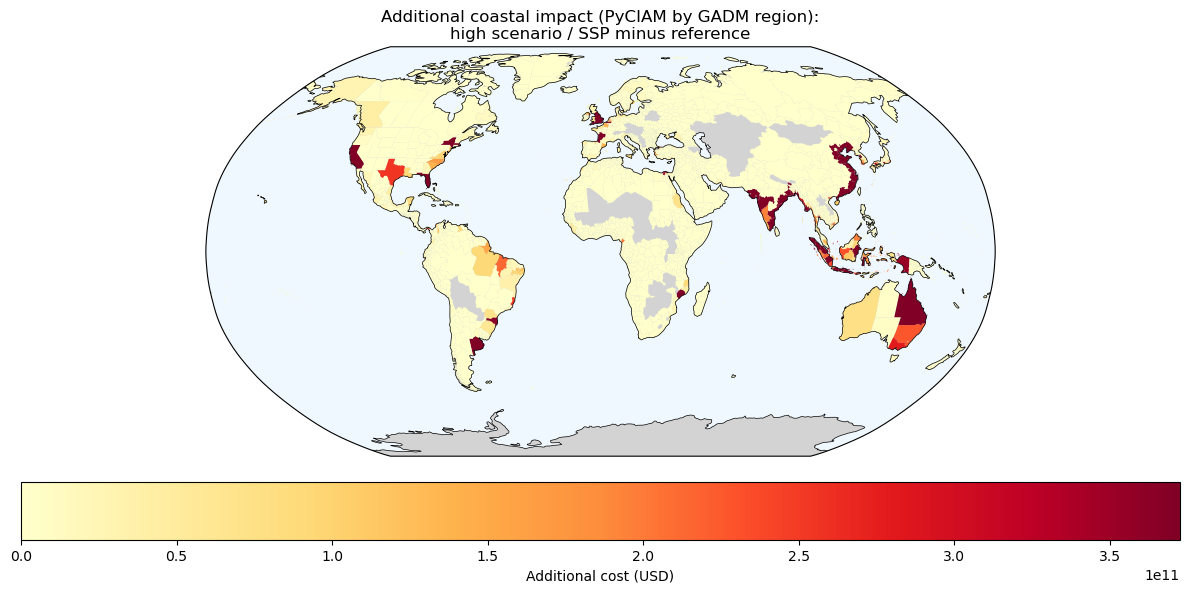

In [10]:
# Plot 7 style using PyCIAM + GADM: choropleth by region (see https://gadm.org)
import geopandas as gpd
import pandas as pd
import fiona

# Reference vs high scenario (same as before)
cost_ref = (
    ds.costs.isel(case=0, scenario=0, ssp=0, iam=0, quantile=0)
    .sum(dim=["year", "costtype"])
    .assign_coords(adm1=ds.adm1.values)
)
cost_hi = (
    ds.costs.isel(case=0, scenario=-1, ssp=-2, iam=0, quantile=0)
    .sum(dim=["year", "costtype"])
    .assign_coords(adm1=ds.adm1.values)
)
cost_diff = (cost_ref - cost_hi).load()

# Build table: adm1 (GADM GID_1) -> cost difference
diff_series = {str(ds.adm1.values[i]): float(cost_diff.isel(adm1=i).values) for i in range(cost_diff.sizes["adm1"])}
diff_df = pd.DataFrame([{"GID_1": k, "cost_diff": v} for k, v in diff_series.items() if np.isfinite(v)])

# Load GADM level 1. Use local file if present; else download only countries in PyCIAM adm1.
# Create gadm folder if it doesn't exist
gadm_dir = Path("gadm")
gadm_dir.mkdir(exist_ok=True)

gadm_path = gadm_dir / "gadm_410.gpkg"
if not gadm_path.exists():
    gadm_path = gadm_dir / "gadm_410-level1.gpkg"
if not gadm_path.exists():
    import urllib.request
    import zipfile
    # Unique country codes from adm1 (GID_0: part before "." or full if no dot, e.g. ABW or AGO)
    adm1_codes = [str(x) for x in ds.adm1.values]
    gid0_set = set()
    for c in adm1_codes:
        if "." in c:
            gid0_set.add(c.split(".")[0])
        else:
            gid0_set.add(c[:3] if len(c) >= 3 else c)
    base_url = "https://geodata.ucdavis.edu/gadm/gadm4.1/gpkg"
    gdf_list = []
    for gid0 in sorted(gid0_set):
        url = f"{base_url}/gadm41_{gid0}.gpkg"
        try:
            path = gadm_dir / f"gadm41_{gid0}.gpkg"
            if not path.exists():
                urllib.request.urlretrieve(url, path)
            layers = fiona.listlayers(str(path))
            l1 = "level1" if "level1" in layers else (layers[1] if len(layers) > 1 else layers[0])
            gdf_list.append(gpd.read_file(path, layer=l1))
        except Exception:
            pass  # skip missing or failed countries
    if not gdf_list:
        raise FileNotFoundError(
            "GADM level-1 not found and auto-download failed. Save gadm_410.gpkg from "
            "https://gadm.org/download_world.html in the gadm folder, or check your connection."
        )
    gdf = pd.concat(gdf_list, ignore_index=True)
else:
    layers = fiona.listlayers(str(gadm_path))
    level1_name = "level1" if "level1" in layers else (layers[1] if len(layers) > 1 else layers[0])
    gdf = gpd.read_file(gadm_path, layer=level1_name)

# Join PyCIAM cost difference to GADM (PyCIAM adm1 = GADM GID_1)
gdf = gdf.merge(diff_df, on="GID_1", how="left")
gdf["cost_diff"] = gdf["cost_diff"].fillna(0)
# Clip to non-negative for display (0 = no additional cost)
gdf["cost_diff_plot"] = gdf["cost_diff"].clip(lower=0)
# Simplify geometries for much faster plotting (tolerance ~0.03 deg at equator)
gdf["geometry"] = gdf.geometry.simplify(0.03, preserve_topology=True)

# Scale so most regions get visible color (use 95th percentile to avoid a few extremes making everything yellow)
positive = gdf["cost_diff_plot"][gdf["cost_diff_plot"] > 0]
vm = float(positive.quantile(0.95)) if len(positive) > 0 else 1.0
if vm <= 0:
    vm = float(gdf["cost_diff_plot"].max()) or 1.0

fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.Robinson())
ax.set_global()
ax.add_feature(cfeature.OCEAN, facecolor="aliceblue")
ax.add_feature(cfeature.LAND, facecolor="lightgray", edgecolor="none")
gdf.plot(
    ax=ax, column="cost_diff_plot", cmap="YlOrRd", vmin=0, vmax=vm,
    transform=ccrs.PlateCarree(), edgecolor="none", linewidth=0.2,
    legend=True, legend_kwds={"orientation": "horizontal", "pad": 0.05, "label": "Additional cost (USD)"},
    rasterized=True
)
ax.coastlines(linewidth=0.5)
ax.set_title("Additional coastal impact (PyCIAM by GADM region):\nhigh scenario / SSP minus reference")
plt.tight_layout()
plt.show()

## GADM choropleth by SSP (SSP1, SSP2, SSP3, SSP5)

Same GADM level-1 map style: total cost by region for each of the four SSPs in separate panels. One scenario, one adaptation case; costs summed over years and cost types. Shared color scale (0 to 95th percentile) for comparison.

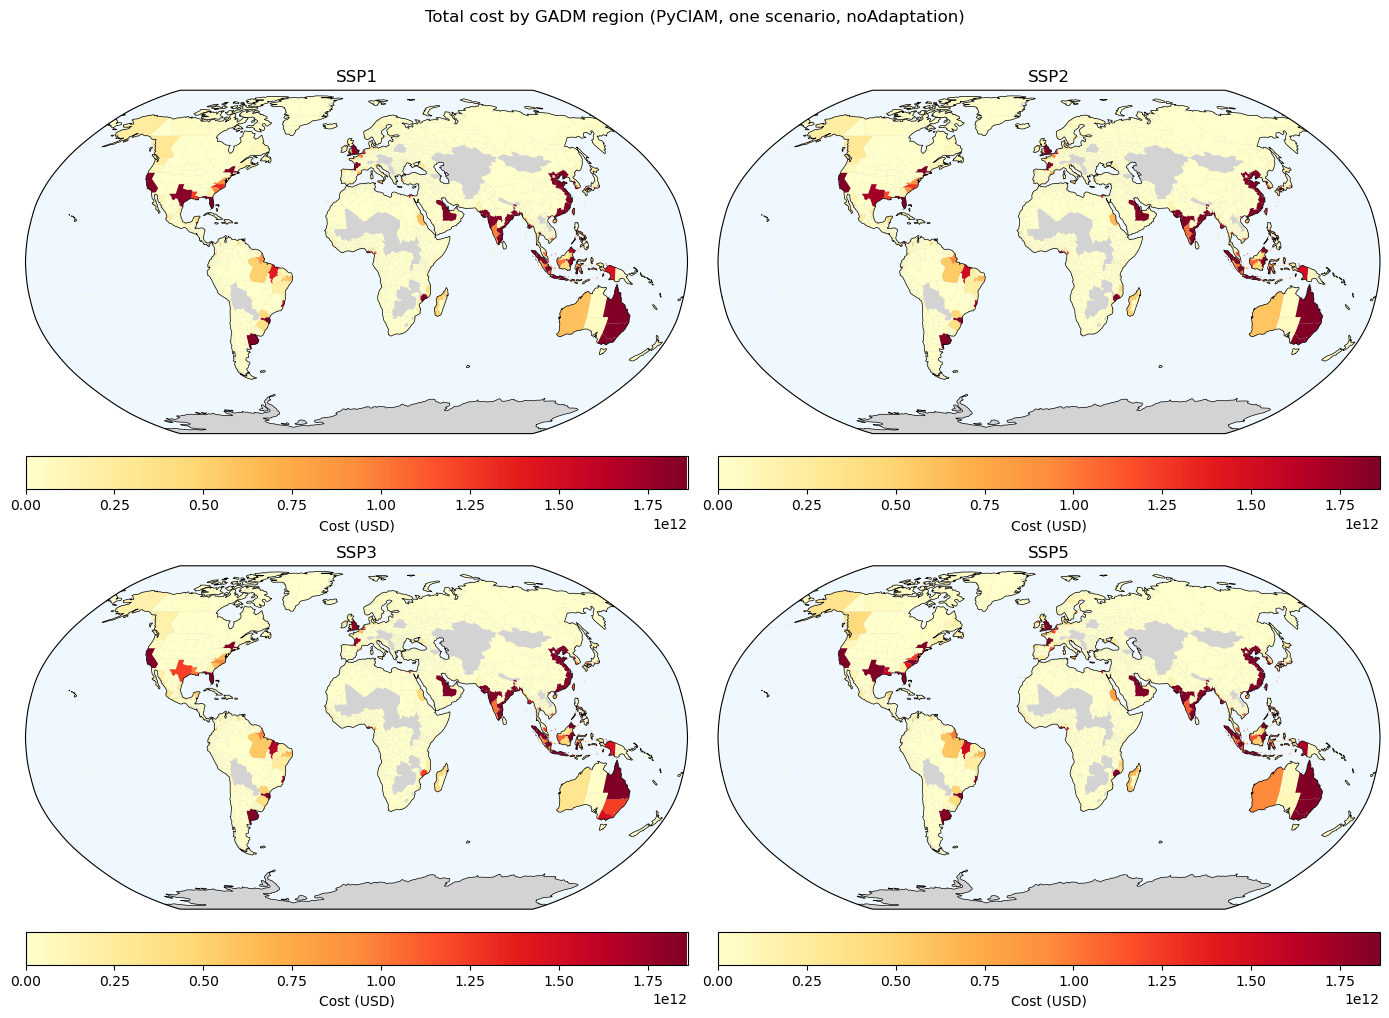

In [9]:
# GADM choropleth by SSP: SSP1, SSP2, SSP3, SSP5 (four panels)
import geopandas as gpd
import pandas as pd
import fiona

ssp_indices = [0, 1, 2, 4]
ssp_labels = ["SSP1", "SSP2", "SSP3", "SSP5"]

# Total cost per adm1 for each SSP (case=0, scenario=0, iam=0, quantile=1; sum over year, costtype)
cost_by_ssp = {}
for i, (idx, label) in enumerate(zip(ssp_indices, ssp_labels)):
    c = (
        ds.costs.isel(case=0, scenario=0, ssp=idx, iam=0, quantile=0)
        .sum(dim=["year", "costtype"])
        .load()
    )
    cost_by_ssp[label] = {str(ds.adm1.values[j]): float(c.isel(adm1=j).values) for j in range(c.sizes["adm1"]) if np.isfinite(c.isel(adm1=j).values)}

# One table: GID_1, cost_SSP1, cost_SSP2, cost_SSP3, cost_SSP5
all_gids = set()
for d in cost_by_ssp.values():
    all_gids.update(d.keys())
cost_df = pd.DataFrame({"GID_1": list(all_gids)})
for label in ssp_labels:
    cost_df[label] = cost_df["GID_1"].map(cost_by_ssp[label]).fillna(0)

# Load GADM (reuse logic from section 7)
# Create gadm folder if it doesn't exist
gadm_dir = Path("gadm")
gadm_dir.mkdir(exist_ok=True)

gadm_path = gadm_dir / "gadm_410.gpkg"
if not gadm_path.exists():
    gadm_path = gadm_dir / "gadm_410-level1.gpkg"
if not gadm_path.exists():
    import urllib.request
    adm1_codes = [str(x) for x in ds.adm1.values]
    gid0_set = set(c.split(".")[0] if "." in c else (c[:3] if len(c) >= 3 else c) for c in adm1_codes)
    base_url = "https://geodata.ucdavis.edu/gadm/gadm4.1/gpkg"
    gdf_list = []
    for gid0 in sorted(gid0_set):
        try:
            path = gadm_dir / f"gadm41_{gid0}.gpkg"
            if not path.exists():
                urllib.request.urlretrieve(f"{base_url}/gadm41_{gid0}.gpkg", path)
            layers = fiona.listlayers(str(path))
            l1 = "level1" if "level1" in layers else (layers[1] if len(layers) > 1 else layers[0])
            gdf_list.append(gpd.read_file(path, layer=l1))
        except Exception:
            pass
    if not gdf_list:
        raise FileNotFoundError("GADM not found. Run the cell above (section 7) first or add gadm_410.gpkg to the gadm folder.")
    gdf = pd.concat(gdf_list, ignore_index=True)
else:
    layers = fiona.listlayers(str(gadm_path))
    level1_name = "level1" if "level1" in layers else (layers[1] if len(layers) > 1 else layers[0])
    gdf = gpd.read_file(gadm_path, layer=level1_name)

gdf = gdf.merge(cost_df, on="GID_1", how="left")
for label in ssp_labels:
    gdf[label] = gdf[label].fillna(0).clip(lower=0)
# Simplify geometries for much faster plotting (tolerance ~0.03 deg)
gdf["geometry"] = gdf.geometry.simplify(0.03, preserve_topology=True)

# Shared color scale: 95th percentile across all four SSP cost columns
all_positive = np.concatenate([gdf[l].values[gdf[l].values > 0] for l in ssp_labels])
vm = float(np.percentile(all_positive, 95)) if len(all_positive) > 0 else 1.0
if vm <= 0:
    vm = max(gdf[l].max() for l in ssp_labels) or 1.0

fig, axes = plt.subplots(2, 2, subplot_kw={"projection": ccrs.Robinson()}, figsize=(14, 10))
for i, label in enumerate(ssp_labels):
    ax = axes.flat[i]
    ax.set_global()
    ax.add_feature(cfeature.OCEAN, facecolor="aliceblue")
    ax.add_feature(cfeature.LAND, facecolor="lightgray", edgecolor="none")
    gdf.plot(ax=ax, column=label, cmap="YlOrRd", vmin=0, vmax=vm,
             transform=ccrs.PlateCarree(), edgecolor="none", linewidth=0.2,
             legend=True, legend_kwds={"orientation": "horizontal", "pad": 0.05, "label": "Cost (USD)"},
             rasterized=True)
    ax.coastlines(linewidth=0.5)
    ax.set_title(label)
plt.suptitle("Total cost by GADM region (PyCIAM, one scenario, noAdaptation)", fontsize=12, y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
ds.close()